In [3]:
from scapy.all import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
def createDataFrame(pkt_lst):
    protos = []
    dst_type = []
    
    for pkt in pkt_lst:
        try:  
            ptype = {
                0x0800: 'IPv4',
                0x0806: 'ARP',
                0x8137: 'IPX',
                0x86dd: 'IPv6'
            }.get(pkt.type, 'Other')
        except AttributeError:
            ptype = 'Other'
            pass
        
        protos.append(ptype)
        isBcast = pkt.dst == 'ff:ff:ff:ff:ff:ff'
        if isBcast:
            dst_type.append("broadcast")
        else:
            dst_type.append("unicast")
    
    data_dict = {'protocolos': protos, 'destinos': dst_type}
    
    return pd.DataFrame.from_dict(data_dict)


def getNoTypePkts(pkt_lst):
    pkts = []

    for pkt in pkt_lst:
        try:  
            ptype = pkt.type
        except AttributeError:
            pkts.append(pkt)
            pass
        
    return pkts


def plotProtocols(dframe, size=(8,8)):
    dframe.protocolos.value_counts(sort=False).plot.pie(figsize=size)

In [5]:
# packets_mc = rdpcap("mc.cap")
# packets_desp = rdpcap("desp.cap")
# packets_naxio = rdpcap("pruebamac.cap")
# packets_home = rdpcap("home.cap")
packets_mh = rdpcap("manu_home.cap")

protocolos  destinos 
ARP         broadcast     1088
            unicast          2
IPv4        broadcast       25
            unicast      28882
IPv6        unicast          3
dtype: int64

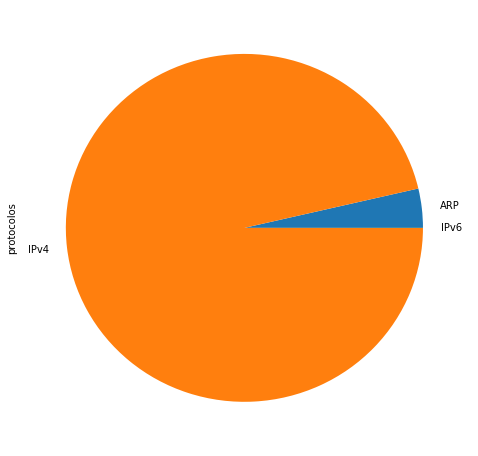

In [24]:
data_mc = createDataFrame(packets_mc)
plotProtocols(data_mc)
data_mc.groupby(['protocolos', 'destinos']).size()

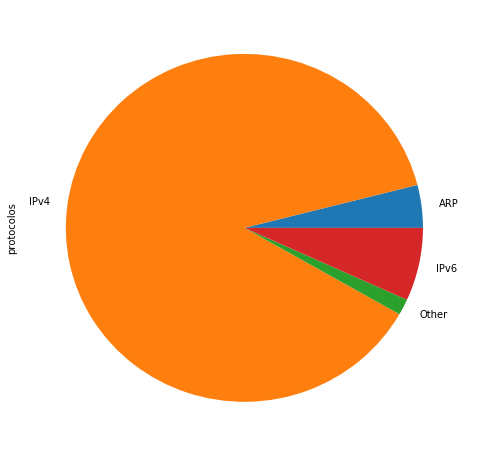

In [21]:
data_desp = createDataFrame(packets_desp)
plotProtocols(data_desp)

Found 0 packets with no type


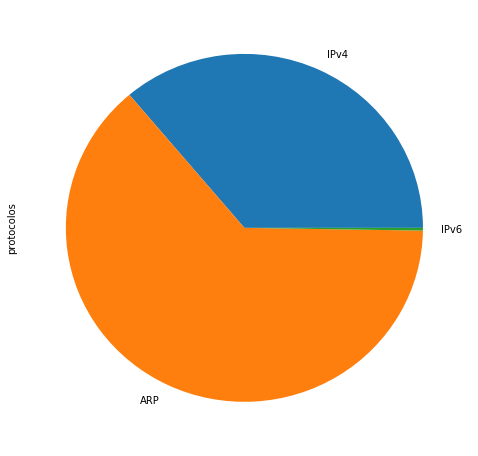

In [11]:
data_naxio = createDataFrame(packets_naxio)
plotProtocols(data_naxio)

Found 1 packets with no type


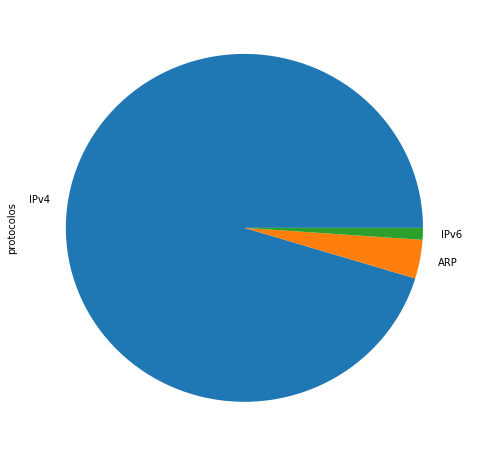

In [12]:
data_home = createDataFrame(packets_home)
plotProtocols(data_home)

Found 0 packets with no type


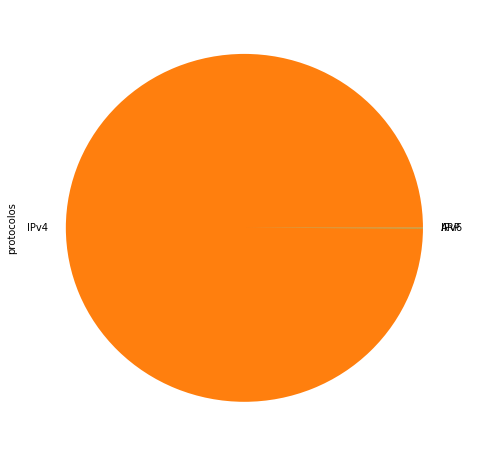

In [9]:
data_mh = createDataFrame(packets_mh)
plotProtocols(data_mh)

In [6]:
def probability_chart(df):
    total =  df.shape[0]
    return (df.groupby(['protocolos', 'destinos']).size() / total).reset_index(name='probabilidad')

In [10]:
probability_chart(data_mh)

,protocolos,destinos,probabilidad
0,ARP,broadcast,0.000067
1,ARP,unicast,0.000033
2,IPv4,broadcast,0.000067
3,IPv4,unicast,0.999467
4,IPv6,unicast,0.000367


In [23]:
getNoTypePkts(packets_home)[0].display()

###[ 802.3 ]### 
  dst       = ff:ff:ff:ff:ff:ff
  src       = d0:53:49:f0:cb:9e
  len       = 46
###[ LLC ]### 
     dsap      = 0x0
     ssap      = 0x1
     ctrl      = 175
###[ Raw ]### 
        load      = '\x81\x01\x00ce:WFADevice:1\r\nUSN: uuid:f7ba9b4f-0606-'



In [ ]:
def entropy(df):
    probs = probability_chart(df)
    sum = 0
    for index, row in probs.iterrows():
        prob = row['probabilidad']
        sum += prob * (- math.log2(prob))
        print(prob, (- math.log2(prob)))
    return sum

In [12]:
entropy(data_mh)

6.666666666666667e-05 13.872674880270605
3.3333333333333335e-05 14.872674880270605
6.666666666666667e-05 13.872674880270605
0.9994666666666666 0.0007696426114188146
0.00036666666666666667 11.413243261633308


0.007299533811336705

In [32]:
def max_entropy(df)
    return math.log2(df.groupby(['protocolos', 'destinos']).size().reset_index().count()[0])

2.321928094887362